In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import skew
from scipy.special import boxcox1p

from sklearn.datasets import load_boston
from sklearn.preprocessing import StandardScaler, MinMaxScaler,RobustScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split, cross_val_score

%matplotlib inline

In [2]:
boston = load_boston()
boston_df = pd.DataFrame(boston.data, columns = boston.feature_names)

In [3]:
boston_df.head(3)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03


In [4]:
boston_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    float64
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    float64
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
dtypes: float64(13)
memory usage: 51.5 KB


# EDA

### 결측값 확인

<AxesSubplot:>

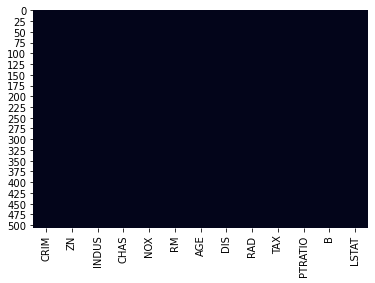

In [5]:
sns.heatmap(boston_df.isnull(), cbar=False)

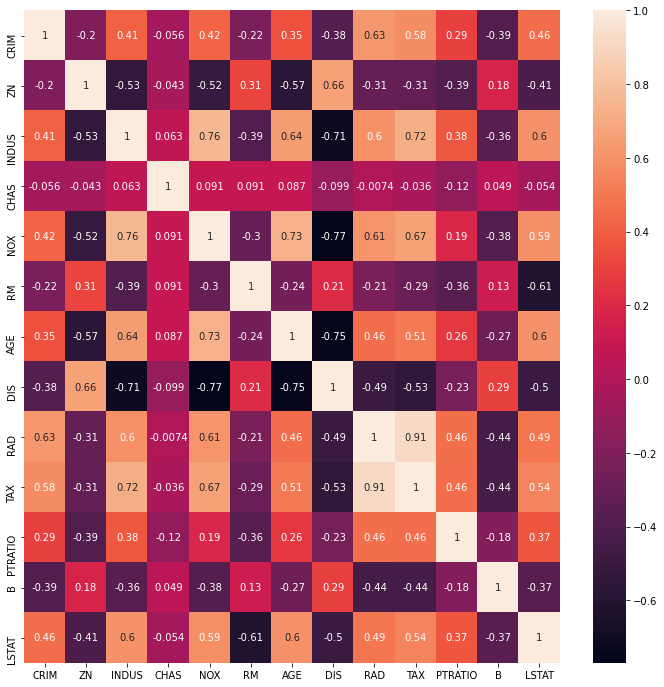

In [6]:
plt.figure(figsize = (12,12))
sns.heatmap(boston_df.corr(), annot=True)
plt.show()

### 회귀 분석

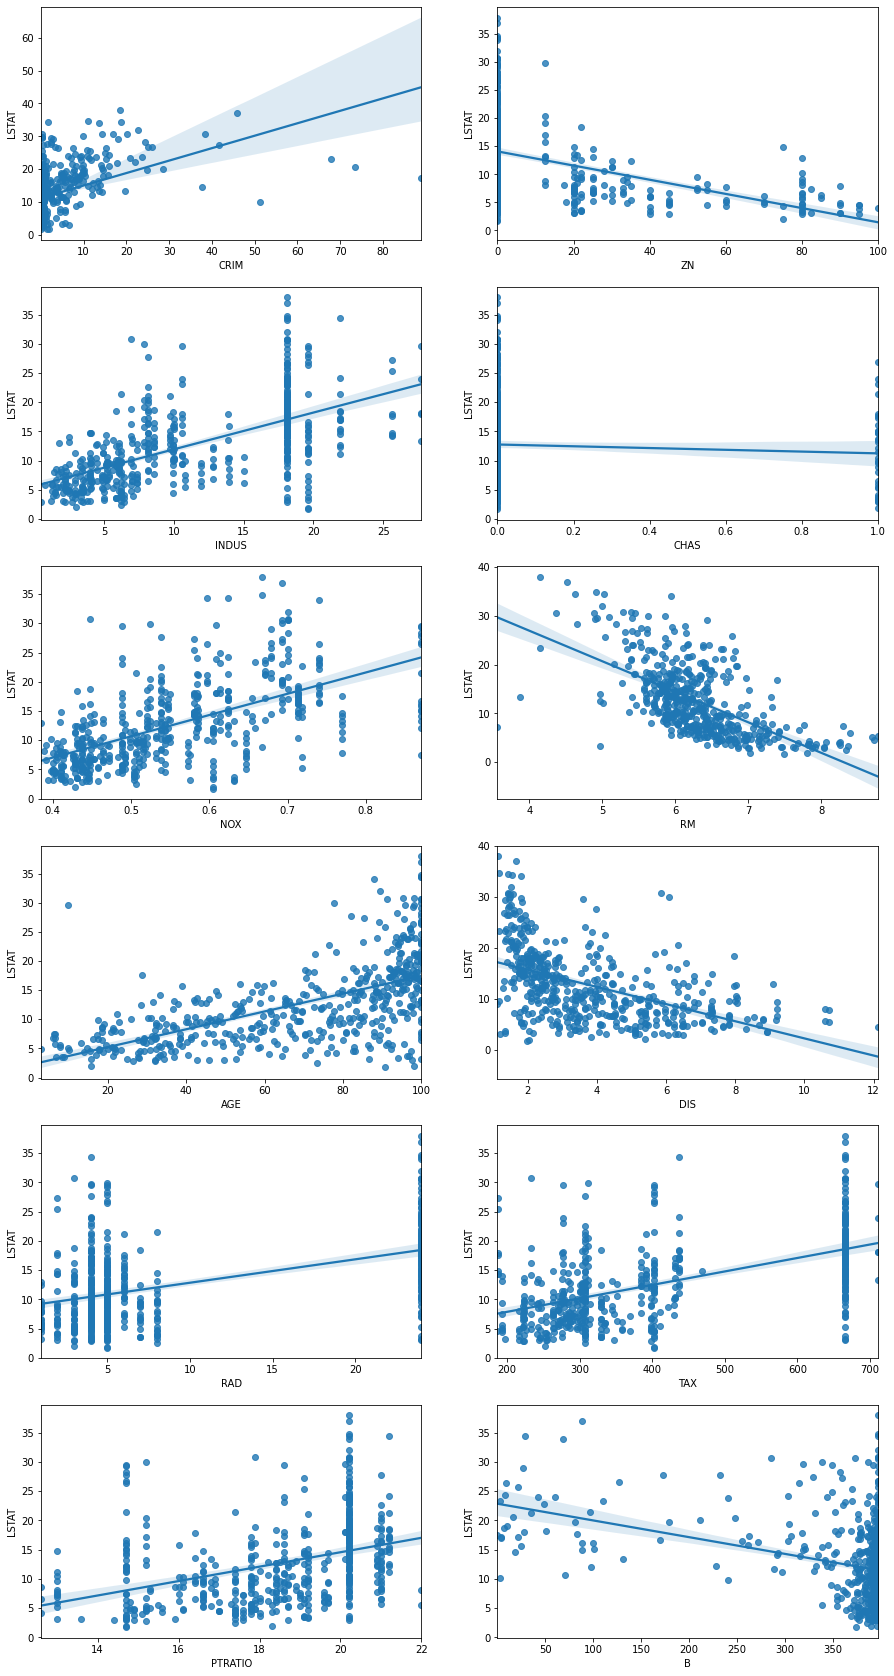

In [7]:
features = list(boston_df.select_dtypes(exclude = 'object').columns)[:-1]
length = len(features)

fig, axs = plt.subplots(figsize=(15, 30), ncols = 2, nrows = 6)
for i, feature in enumerate(features):
    row = int(i/2)
    col = i%2
    sns.regplot(x = feature, y='LSTAT', data=boston_df, ax = axs[row][col])

## Target Data

### 왜도 확인

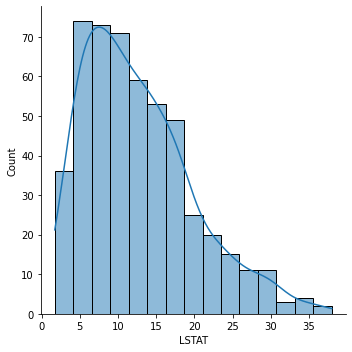

In [8]:
sns.displot(boston_df.LSTAT, kde=True)
plt.show()

### 정규성 확인

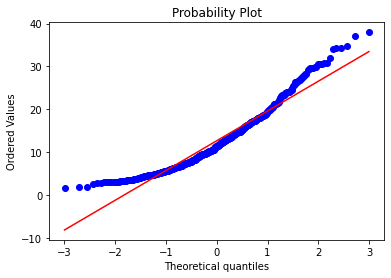

In [9]:
stats.probplot(boston_df.LSTAT, plot=plt)# QQ-plot
plt.show()

### Target data 로그 변환

In [10]:
boston_df.LSTAT = np.log1p(boston_df.LSTAT)

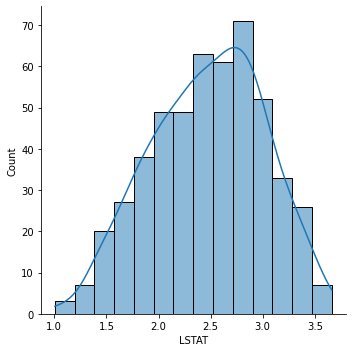

In [11]:
sns.displot(boston_df.LSTAT, kde=True)
plt.show()

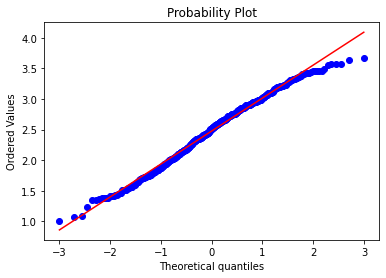

In [12]:
stats.probplot(boston_df.LSTAT, plot=plt)
plt.show()

### Train Data 왜도

In [13]:
features = boston_df.select_dtypes(exclude = 'object').columns

skewness = boston_df[features].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)

In [14]:
skewness

CRIM       5.207652
CHAS       3.395799
ZN         2.219063
DIS        1.008779
RAD        1.001833
NOX        0.727144
TAX        0.667968
RM         0.402415
INDUS      0.294146
LSTAT     -0.186640
AGE       -0.597186
PTRATIO   -0.799945
B         -2.881798
dtype: float64

In [15]:
def scaler(df, features):
    df_copy = df[features].copy()
    
    ss = StandardScaler()
    ss_df = ss.fit_transform(df_copy)
    print('#'*10, ' StandardScaler ', '#'*10)
    print(pd.DataFrame(ss_df).apply(lambda x: skew(x)))
    df_copy = df[features].copy()
    
    mm = MinMaxScaler()
    mm_df = mm.fit_transform(df_copy)
    print('#'*10, ' MinMaxScaler ', '#'*10)
    print(pd.DataFrame(mm_df).apply(lambda x: skew(x)))
    df_copy = df[features].copy()
    
    rs = RobustScaler()
    rs_df = rs.fit_transform(df_copy)
    print('#'*10, ' RobustScaler ', '#'*10)
    print(pd.DataFrame(rs_df).apply(lambda x: skew(x)))
    df_copy = df[features].copy()
    
    lamd = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3]
    for lam in lamd:
        df_copy1 = pd.DataFrame()
        for feature in features:
            df_copy1[feature] = boxcox1p(df_copy[feature], lam)
        
        print('#'*10, f' BoxCox Transformation_{lam} ', '#'*10)
        print(df_copy1.apply(lambda x: skew(x)))

In [16]:
check = ['CRIM','CHAS', 'ZN', 'B']
scaler(boston_df.iloc[:,:-1], check)

##########  StandardScaler  ##########
0    5.207652
1    3.395799
2    2.219063
3   -2.881798
dtype: float64
##########  MinMaxScaler  ##########
0    5.207652
1    3.395799
2    2.219063
3   -2.881798
dtype: float64
##########  RobustScaler  ##########
0    5.207652
1    3.395799
2    2.219063
3   -2.881798
dtype: float64
##########  BoxCox Transformation_0.05  ##########
CRIM    1.336929
CHAS    3.395799
ZN      1.213143
B      -4.270415
dtype: float64
##########  BoxCox Transformation_0.1  ##########
CRIM    1.416207
CHAS    3.395799
ZN      1.239675
B      -4.114259
dtype: float64
##########  BoxCox Transformation_0.15  ##########
CRIM    1.504306
CHAS    3.395799
ZN      1.269714
B      -3.975157
dtype: float64
##########  BoxCox Transformation_0.2  ##########
CRIM    1.602348
CHAS    3.395799
ZN      1.303420
B      -3.851069
dtype: float64
##########  BoxCox Transformation_0.25  ##########
CRIM    1.711526
CHAS    3.395799
ZN      1.340897
B      -3.740135
dtype: float64
######

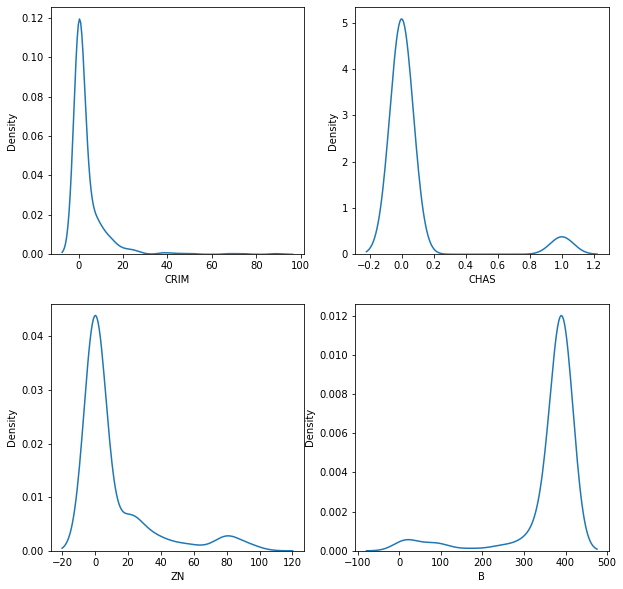

In [17]:
fig, axs = plt.subplots(figsize = (10,10), ncols=2, nrows=2)

check = ['CRIM','CHAS', 'ZN', 'B']
for i, feature in  enumerate(check):
    row = int(i/2)
    col = i%2
    sns.kdeplot(x=feature, data=boston_df, ax=axs[row][col])

In [18]:
lam = 0.05
for feature in check:
    boston_df[feature] = boxcox1p(boston_df[feature], lam)

In [19]:
skewness = boston_df[features].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewness

CHAS       3.395799
CRIM       1.336929
ZN         1.213143
DIS        1.008779
RAD        1.001833
NOX        0.727144
TAX        0.667968
RM         0.402415
INDUS      0.294146
LSTAT     -0.186640
AGE       -0.597186
PTRATIO   -0.799945
B         -4.270415
dtype: float64

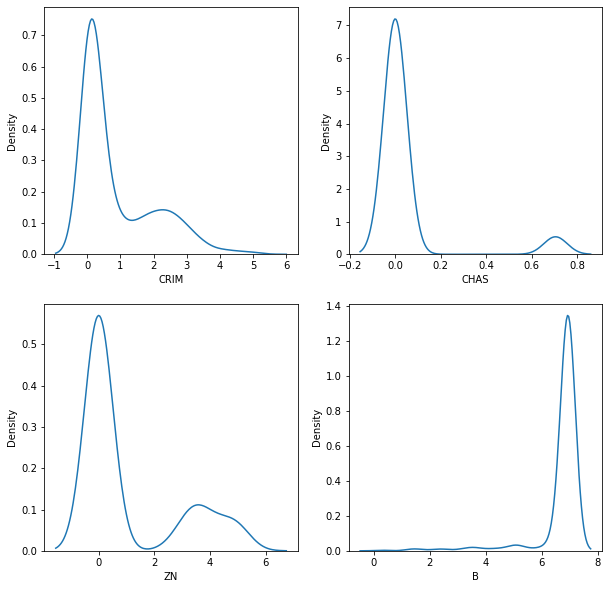

In [20]:
fig, axs = plt.subplots(figsize = (10,10), ncols=2, nrows=2)

for i, feature in  enumerate(check):
    row = int(i/2)
    col = i%2
    sns.kdeplot(x=feature, data=boston_df, ax=axs[row][col])

## 데이터 셋 분리

In [21]:
boston_target = boston_df.iloc[:, -1]
boston_features = boston_df.iloc[:, :-1]

In [22]:
x_train, x_test, y_train, y_test = train_test_split(boston_features, boston_target, test_size=0.3, random_state=830)

## 모델링

In [23]:
lr = LinearRegression()
ridge = Ridge()
lasso = Lasso()
rf_reg = RandomForestRegressor(n_estimators = 500)
xgb_reg = XGBRegressor(n_estimators = 500)
lgb_reg = LGBMRegressor(n_estimators = 500)

In [24]:
def modeling(x_train, x_test, y_train, y_test, model = None):
    model.fit(x_train, y_train)
    pred = model.predict(x_test)
    print('#####', model.__class__.__name__, '#####')
    rmse = np.sqrt(mean_squared_error(y_test, pred))
    mse = mean_absolute_error(y_test, pred)
    print(f'RMSE: {rmse:.4f}, MSE: {mse:.4f}')

In [25]:
for model in [lr, ridge, lasso, rf_reg, xgb_reg, lgb_reg]:
    modeling(x_train, x_test, y_train, y_test, model)

##### LinearRegression #####
RMSE: 0.3193, MSE: 0.2214
##### Ridge #####
RMSE: 0.3190, MSE: 0.2210
##### Lasso #####
RMSE: 0.4137, MSE: 0.3077
##### RandomForestRegressor #####
RMSE: 0.2980, MSE: 0.2045
##### XGBRegressor #####
RMSE: 0.3478, MSE: 0.2432
##### LGBMRegressor #####
RMSE: 0.2825, MSE: 0.2096
